In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def preprocess_data():
    df = pd.read_csv('Mall_Customers.csv')
    df_original = df.copy()  # Keep original for comparison

    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values found:")
        print(missing)
        print("\nOriginal data head:")
        print(df_original.head())
        print("\nData after handling missing values:")
        # Assuming no imputation, just drop or note
        print("(No imputation applied, proceeding)")

    # Check for duplicates
    duplicates = df[df.duplicated()]
    if len(duplicates) > 0:
        print(f"\n{len(duplicates)} duplicate rows found:")
        print(duplicates)
        print("\nOriginal data head:")
        print(df_original.head())

        # Data cleaning (drop duplicates)
        df = df.drop_duplicates()
        print("\nData after removing duplicates:")
        print(df.head())

    # Initial feature selection <------如果你做完visualization後要去掉不相干的特徵,在這邊修改
    df = df.drop(columns=['CustomerID'])  # Assuming CustomerID is not useful for analysis

    # Data preprocessing: OneHot encode categorical variable (Genre)
    ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid multicollinearity
    genre_encoded = ohe.fit_transform(df[['Genre']])
    genre_df = pd.DataFrame(genre_encoded, columns=ohe.get_feature_names_out(['Genre']))
    df = pd.concat([df.drop(columns=['Genre']), genre_df], axis=1)

    # Data preprocessing: Scale numerical features appropriately
    scaler = StandardScaler()
    numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df

if __name__ == '__main__':
    # Load and display original data
    df_original = pd.read_csv('Mall_Customers.csv')
    print("Original Dataset info (Schema):")
    df_original.info()
    print("\nOriginal Dataset head (First 5 rows):")
    print(df_original.head())

    df = preprocess_data()

    print("\nOneHot encoded Genre: Created Genre_Male (1 if Male, 0 otherwise)")
    print("Scaled numerical features using StandardScaler.")
    print("Processed dataset head (after preprocessing):")
    print(df.head())


Original Dataset info (Schema):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Original Dataset head (First 5 rows):
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17          


Running KMeans++ (testing k from 2 to 5 for elbow plot)
KMeans k=2: silhouette=0.303, calinski_harabasz=95.2, inertia=438.5
KMeans k=3: silhouette=0.315, calinski_harabasz=87.0, inertia=344.7
KMeans k=4: silhouette=0.350, calinski_harabasz=101.5, inertia=254.3
KMeans k=5: silhouette=0.350, calinski_harabasz=97.3, inertia=216.8

Cluster summary (mean and count):
              Age       Annual Income (k$)       Spending Score (1-100)        \
             mean count               mean count                   mean count   
Cluster                                                                         
0        1.198627    58          -0.460981    58              -0.327038    58   
1       -0.441917    39           0.991583    39               1.239503    39   
2       -0.781722    47          -0.403069    47              -0.215914    47   
3        0.173295    34           1.066454    34              -1.298010    34   
4       -0.974396    22          -1.329545    22               1.132

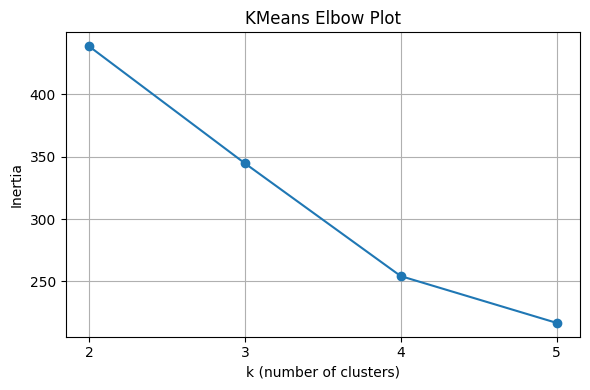

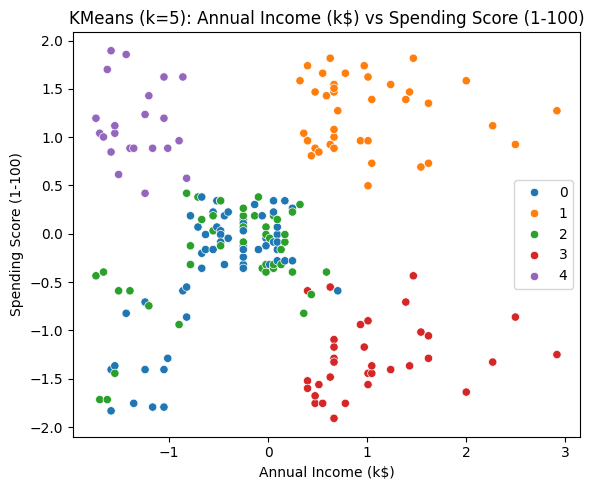

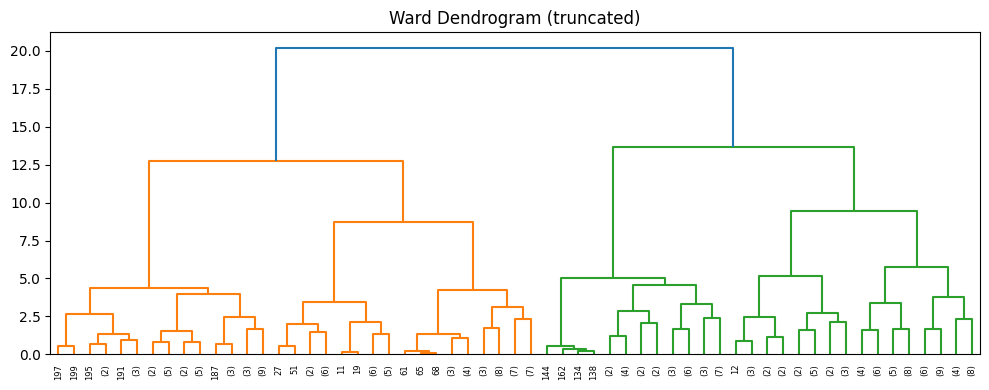

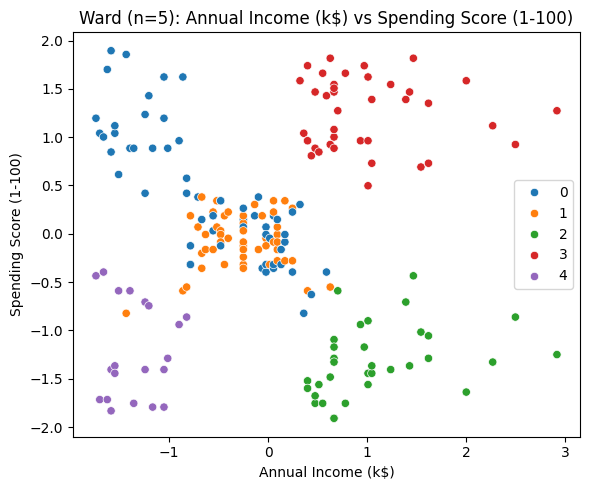

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

try:
    from scipy.cluster.hierarchy import dendrogram, linkage
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

# Global k number for clustering
K_NUM = 5

# Import processed dataframe from data.py (expects `df` to be defined there)
try:
    from data import preprocess_data
    df = preprocess_data()
except Exception as e:
    print('Failed to import and preprocess data from data.py:', e)
    sys.exit(1)

OUT_DIR = 'pic'
os.makedirs(OUT_DIR, exist_ok=True)

# Run KMeans++ clustering
def run_kmeans(features, ks=range(2, 7)):
    results = {}
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        labels = km.fit_predict(features)
        sil = silhouette_score(features, labels)
        ch = calinski_harabasz_score(features, labels)
        results[k] = {'model': km, 'labels': labels, 'silhouette': sil, 'calinski_harabasz': ch, 'inertia': km.inertia_}
        inertias.append(km.inertia_)
        print(f"KMeans k={k}: silhouette={sil:.3f}, calinski_harabasz={ch:.1f}, inertia={km.inertia_:.1f}")

    # Plot inertia (elbow)
    plt.figure(figsize=(6, 4))
    plt.plot(list(ks), inertias, marker='o')
    plt.xticks(list(ks))
    plt.xlabel('k (number of clusters)')
    plt.ylabel('Inertia')
    plt.title('KMeans Elbow Plot')
    plt.grid(True)
    elbow_path = os.path.join(OUT_DIR, 'kmeans_elbow.png')
    plt.tight_layout()
    plt.savefig(elbow_path)
    return results

# Run Ward's Agglomerative Clustering
def run_ward(features, n_clusters=5):
    # Agglomerative clustering with Ward linkage
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = ward.fit_predict(features)
    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)
    print(f"Ward Agglomerative n_clusters={n_clusters}: silhouette={sil:.3f}, calinski_harabasz={ch:.1f}")

    # Dendrogram (requires scipy library, make sure it's installed)
    if SCIPY_AVAILABLE:
        Z = linkage(features, method='ward')
        plt.figure(figsize=(10, 4))
        dendrogram(Z, truncate_mode='level', p=5)
        plt.title('Ward Dendrogram (truncated)')
        dend_path = os.path.join(OUT_DIR, 'ward_dendrogram.png')
        plt.tight_layout()
        plt.savefig(dend_path)
    else:
        print('scipy not available — skipping dendrogram (install scipy to enable)')

    return {'model': ward, 'labels': labels, 'silhouette': sil, 'calinski_harabasz': ch}

# Visualization of clusters in 2D (using first two features for default, can be modified)
def plot_clusters_2d(features, labels, title_prefix='cluster', save_name='clusters.png'):
    cols = list(features.columns) if hasattr(features, 'columns') else []
    if 'Annual Income (k$)' in cols and 'Spending Score (1-100)' in cols: # Modified xcol, ycol label here
        xcol, ycol = 'Annual Income (k$)', 'Spending Score (1-100)'
    else:
        # fallback to first two columns
        xcol, ycol = cols[0], cols[1]

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=features[xcol], y=features[ycol], hue=labels, palette='tab10', legend='full')
    plt.title(f'{title_prefix}: {xcol} vs {ycol}')
    plt.tight_layout()
    path = os.path.join(OUT_DIR, save_name)
    plt.savefig(path)

def summarize_clusters(features, labels):
    dfc = features.copy()
    dfc['Cluster'] = labels
    summary = dfc.groupby('Cluster').agg(['mean','count'])
    print('\nCluster summary (mean and count):')
    print(summary)

def main():
    # features: use all columns in df (already preprocessed in data.py)
    features = df.copy()

    # Run KMeans with range up to K_NUM for elbow plot, but use K_NUM as final k
    print(f'\nRunning KMeans++ (testing k from 2 to {K_NUM} for elbow plot)')
    kmeans_results = run_kmeans(features, ks=range(2, K_NUM+1))

    labels = kmeans_results[K_NUM]['labels']
    plot_clusters_2d(df, labels, title_prefix=f'KMeans (k={K_NUM})', save_name=f'kmeans_k{K_NUM}_clusters.png')
    summarize_clusters(df, labels)

    print("\n----------------------------------------------")
    # Run Ward's method with same k
    print(f'\nRunning Ward\'s method (Agglomerative Clustering, n_clusters={K_NUM})')
    ward_res = run_ward(features, n_clusters=K_NUM)
    plot_clusters_2d(df, ward_res['labels'], title_prefix=f'Ward (n={K_NUM})', save_name=f'ward_n{K_NUM}_clusters.png')
    summarize_clusters(df, ward_res['labels'])

if __name__ == '__main__':
    main()


PCA results: explained variance71.77%


d:\anaconda\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anacond

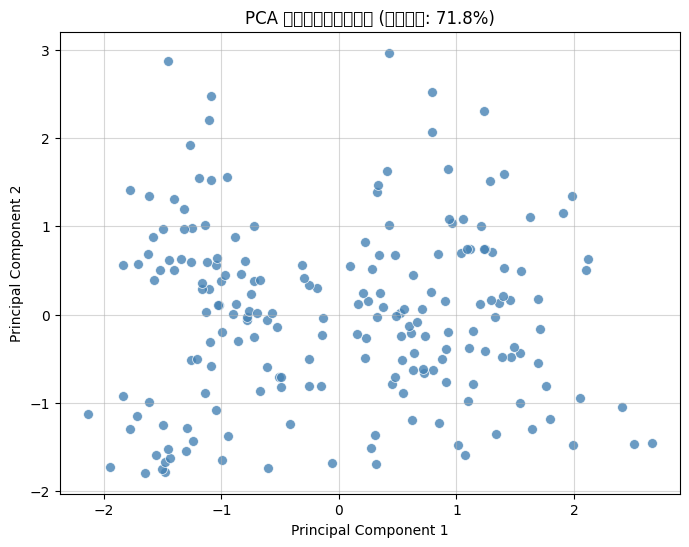

In [8]:

from sklearn.decomposition import PCA

# copy data after preprocessing
features = df.copy() 

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

explained_variance_ratio = pca.explained_variance_ratio_.sum() * 100
print(f"PCA results: explained variance{explained_variance_ratio:.2f}%")

pca_df = pd.DataFrame(
    data = principal_components, 
    columns = ['Principal Component 1', 'Principal Component 2']
)


plt.figure(figsize=(8, 6))


sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2', 
    data=pca_df, 
    color='steelblue',   
    s=50,
    alpha=0.8
)

plt.title(f'PCA 投影后的数据分布图 (解释方差: {explained_variance_ratio:.1f}%)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.5)


plt.show() 

PCA explained variance: 71.77%


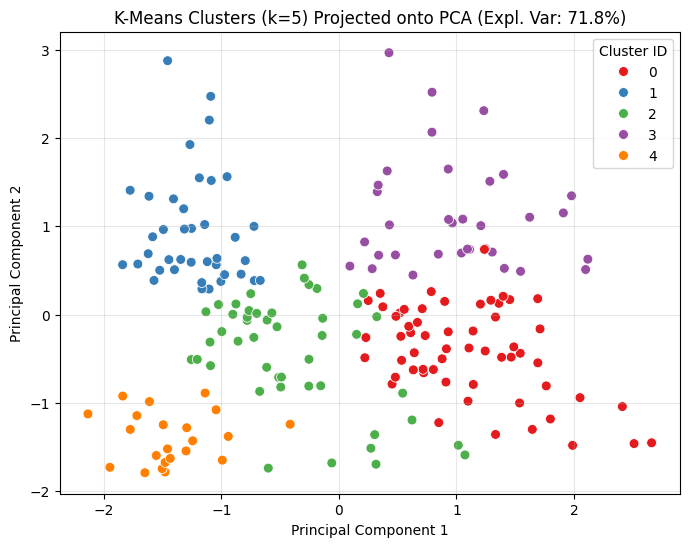

In [ ]:
# PCA
# Using Kmeans to show different cluster after PCA
K_NUM = 5 

# Using PCA to reduce the dim 
features = df.copy()
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

# 2. Using first two principle component
pca_df = pd.DataFrame(
    data = principal_components, 
    columns = ['Principal Component 1', 'Principal Component 2']
)

explained_variance_ratio = pca.explained_variance_ratio_.sum() * 100
print(f"PCA explained variance: {explained_variance_ratio:.2f}%")

from sklearn.cluster import KMeans

# using previous cluster method again
km = KMeans(n_clusters=K_NUM, init='k-means++', random_state=42, n_init=10)
km.fit(features)
labels = km.labels_
 

pca_df['Cluster'] = labels


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2', 
    data=pca_df, 
    hue='Cluster',            # different clusters use different color
    palette='Set1',          
    s=50                   
)

plt.title(f'K-Means Clusters (k={K_NUM}) Projected onto PCA (Expl. Var: {explained_variance_ratio:.1f}%)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()



--- Applying t-SNE ---


d:\anaconda\envs\d2l\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE time: 0.60 秒


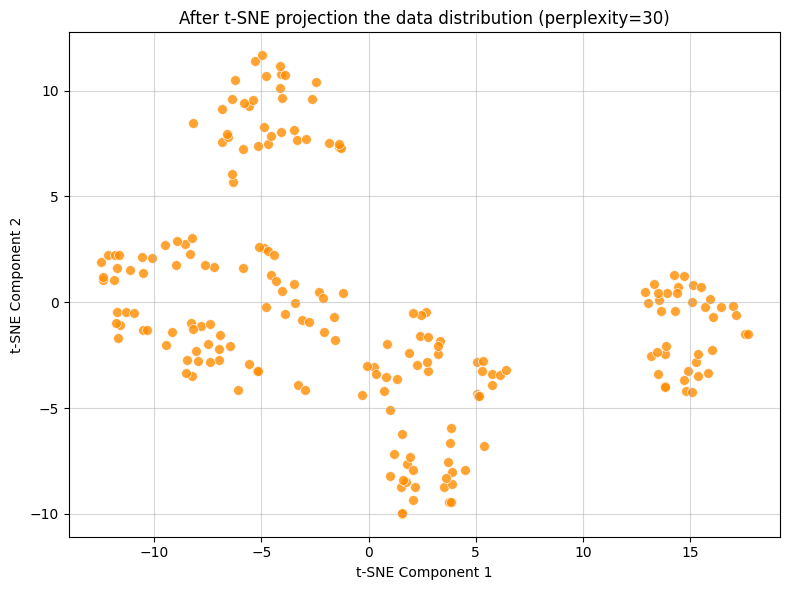

In [11]:
from sklearn.manifold import TSNE
import time

features = df.copy() 

print("\n--- Applying t-SNE ---")
start_time = time.time()


tsne = TSNE(
    n_components=2, 
    perplexity=30, 
    n_iter=1000, 
    random_state=42,
    learning_rate='auto', 
    init='pca'            # Using PCA for initialization to make it more stable
)
tsne_results = tsne.fit_transform(features)

end_time = time.time()
print(f"t-SNE time: {end_time - start_time:.2f} 秒")


tsne_df = pd.DataFrame(
    data = tsne_results, 
    columns = ['t-SNE Component 1', 't-SNE Component 2']
)

# --- 可视化 ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='t-SNE Component 1', 
    y='t-SNE Component 2', 
    data=tsne_df, 
    color='darkorange',   
    s=50,
    alpha=0.8
)

plt.title('After t-SNE projection the data distribution (perplexity=30)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.5)

tsne_path = os.path.join(OUT_DIR, 'tsne_projection_structure.png')
plt.tight_layout()
plt.savefig(tsne_path)
plt.show()

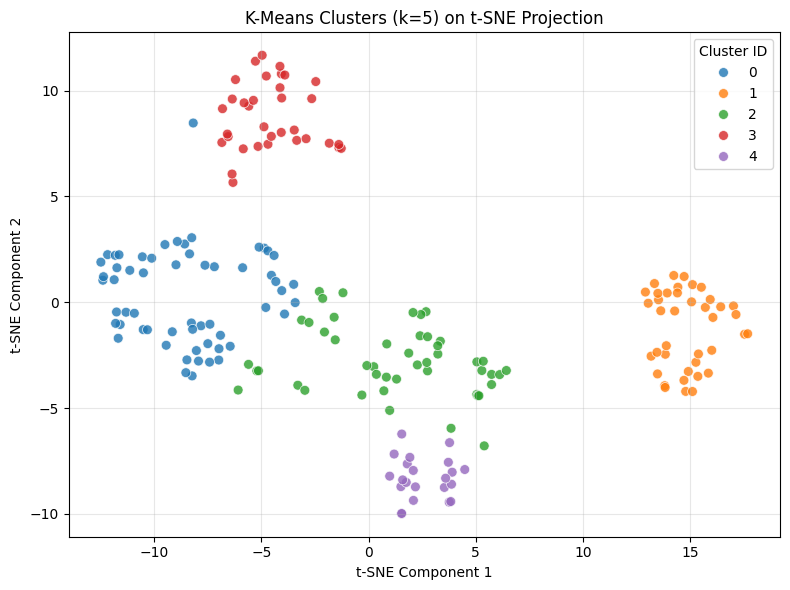

In [12]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 



tsne_df = pd.DataFrame(
    data = tsne_results, 
    columns = ['t-SNE Component 1', 't-SNE Component 2']
)
# Add K-Means cluster label
tsne_df['Cluster'] = labels 

# --- visualization ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='t-SNE Component 1', 
    y='t-SNE Component 2', 
    data=tsne_df, 
    hue='Cluster',           
    palette='tab10',         
    s=50,
    alpha=0.8
)

plt.title(f'K-Means Clusters (k={K_NUM}) on t-SNE Projection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster ID')
plt.grid(True, alpha=0.3)

tsne_cluster_path = os.path.join(OUT_DIR, f'tsne_k{K_NUM}_clusters.png')
plt.tight_layout()
plt.savefig(tsne_cluster_path)
plt.show()

--- K-Means 最佳 K 值搜索 ---
KMeans k=2: Silhouette Score=0.303, Calinski-Harabasz Score=95.2, Inertia=438.5
KMeans k=3: Silhouette Score=0.315, Calinski-Harabasz Score=87.0, Inertia=344.7
KMeans k=4: Silhouette Score=0.350, Calinski-Harabasz Score=101.5, Inertia=254.3
KMeans k=5: Silhouette Score=0.350, Calinski-Harabasz Score=97.3, Inertia=216.8
KMeans k=6: Silhouette Score=0.356, Calinski-Harabasz Score=99.7, Inertia=182.0
KMeans k=7: Silhouette Score=0.343, Calinski-Harabasz Score=92.3, Inertia=167.8
KMeans k=8: Silhouette Score=0.330, Calinski-Harabasz Score=90.8, Inertia=150.7
KMeans k=9: Silhouette Score=0.340, Calinski-Harabasz Score=87.8, Inertia=138.9
KMeans k=10: Silhouette Score=0.309, Calinski-Harabasz Score=81.7, Inertia=133.3

K-Means 最佳 K 值: 6 (Silhouette Score: 0.356)


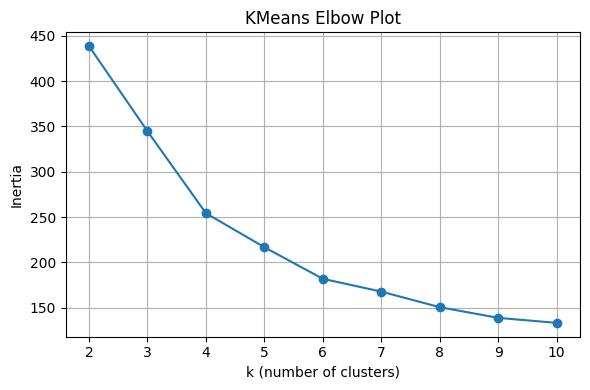

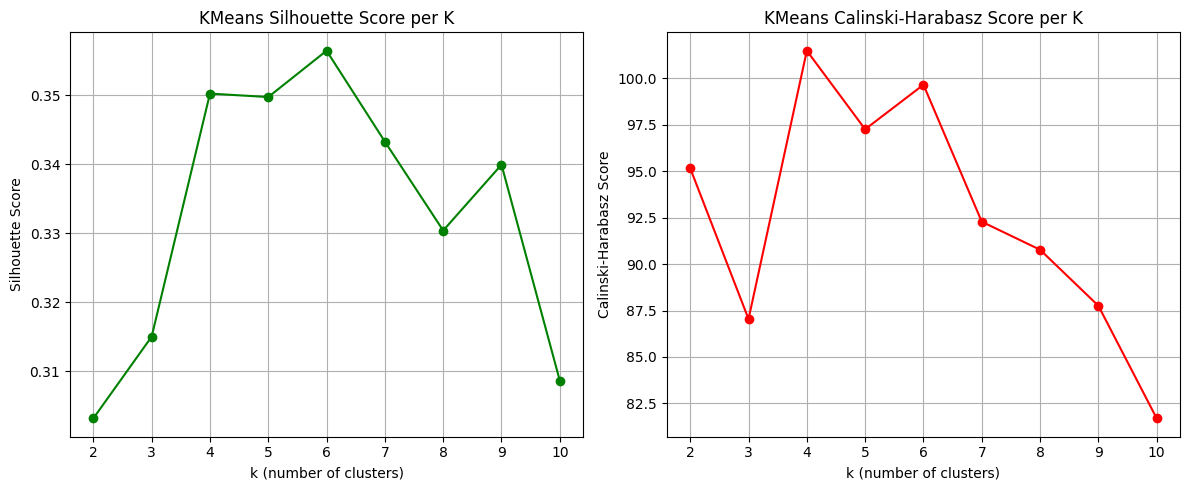

In [ ]:
print("--- Searching for K-Means best K ---")


K_RANGE = range(2, 11) 

best_kmeans_score = -np.inf 
best_k = 0
kmeans_results = {} # store to paint Elbow Plot

# used for Elbow Plot
inertias = []
silhouette_scores = []
ch_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = km.fit_predict(features)
    
    # measureing metric
    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)
    
    inertias.append(km.inertia_)
    silhouette_scores.append(sil)
    ch_scores.append(ch)
    
    print(f"KMeans k={k}: Silhouette Score={sil:.3f}, Calinski-Harabasz Score={ch:.1f}, Inertia={km.inertia_:.1f}")

    # record the best K
    if sil > best_kmeans_score:
        best_kmeans_score = sil
        best_k = k

print(f"\nK-Means 最佳 K 值: {best_k} (Silhouette Score: {best_kmeans_score:.3f})")


# 1. Elbow Plot
plt.figure(figsize=(6, 4))
plt.plot(list(K_RANGE), inertias, marker='o')
plt.xticks(list(K_RANGE))
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Plot')
plt.grid(True)
elbow_path = os.path.join(OUT_DIR, 'kmeans_elbow.png')
plt.tight_layout()
plt.savefig(elbow_path)
plt.show()

# 2. Calinski-Harabasz Score Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(K_RANGE), silhouette_scores, marker='o', color='green')
plt.xticks(list(K_RANGE))
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score per K')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(K_RANGE), ch_scores, marker='o', color='red')
plt.xticks(list(K_RANGE))
plt.xlabel('k (number of clusters)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('KMeans Calinski-Harabasz Score per K')
plt.grid(True)

score_path = os.path.join(OUT_DIR, 'kmeans_scores.png')
plt.tight_layout()
plt.savefig(score_path)
plt.show()


K_NUM = best_k


--- Searching for Agglomerative Clustering best hyperparameter ---

Agglomerative best hyperparameter:
N_clusters: 5
Linkage: average
Best Silhouette Score: 0.351


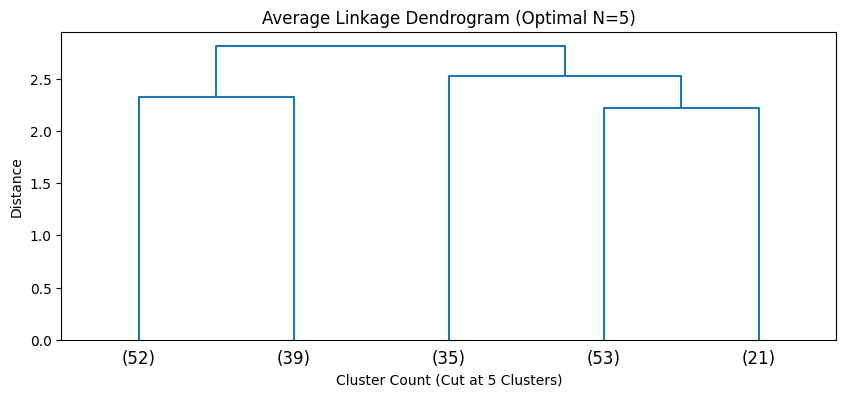

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Searching for Agglomerative Clustering best hyperparameter ---")

# searching range
N_RANGE = range(2, 11)
LINKAGE_METHODS = ['ward', 'complete', 'average', 'single']

best_agg_score = -np.inf
best_n = 0
best_linkage = ''

for linkage_method in LINKAGE_METHODS:
    # Ward can only be used with Euclidean distance
    if linkage_method == 'ward':
        affinity = 'euclidean'
    else:
        affinity = 'euclidean'

    for n in N_RANGE:
        try:
            agg = AgglomerativeClustering(n_clusters=n, linkage=linkage_method, metric=affinity)
            labels = agg.fit_predict(features)

            sil = silhouette_score(features, labels)
            ch = calinski_harabasz_score(features, labels)

            if sil > best_agg_score:
                best_agg_score = sil
                best_n = n
                best_linkage = linkage_method

        except Exception as e:
            continue

print(f"\nAgglomerative best hyperparameter:")
print(f"N_clusters: {best_n}")
print(f"Linkage: {best_linkage}")
print(f"Best Silhouette Score: {best_agg_score:.3f}")

if SCIPY_AVAILABLE:
    Z = linkage(features, method=best_linkage)  # 这里不会再冲突

    plt.figure(figsize=(10, 4))
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=best_n,
        show_leaf_counts=True,
        orientation='top'
    )

    plt.title(f'{best_linkage.capitalize()} Linkage Dendrogram (Optimal N={best_n})')
    plt.xlabel(f'Cluster Count (Cut at {best_n} Clusters)')
    plt.ylabel('Distance')
    plt.show()


In [32]:
from sklearn.cluster import KMeans
import pandas as pd


df = preprocess_data()

# -------------------------------
# ✅ 选择聚类方法：KMeans
# -------------------------------
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df)

# 
cluster_labels = {
    0: "Older, Low Spending",
    1: "Young, Wealthy Spenders",
    2: "Young, Low Income",
    3: "Affluent but Cautious",
    4: "Young, Impulsive Spenders"
}

df["Segment"] = df["Cluster"].map(cluster_labels)


print("\nCluster Profiles:")
for cluster, label in cluster_labels.items():
    subset = df[df["Cluster"] == cluster]
    print(f"\nCluster {cluster} - {label}")
    print(subset.describe().T[["mean"]])

# -------------------------------
# ✅ 输出结果预览
# -------------------------------
print("\nProcessed dataset with cluster segments:")
print(df.head())



Cluster Profiles:

Cluster 0 - Older, Low Spending
                            mean
Age                     1.198627
Annual Income (k$)     -0.460981
Spending Score (1-100) -0.327038
Genre_Male              0.431034
Cluster                 0.000000

Cluster 1 - Young, Wealthy Spenders
                            mean
Age                    -0.441917
Annual Income (k$)      0.991583
Spending Score (1-100)  1.239503
Genre_Male              0.461538
Cluster                 1.000000

Cluster 2 - Young, Low Income
                            mean
Age                    -0.781722
Annual Income (k$)     -0.403069
Spending Score (1-100) -0.215914
Genre_Male              0.340426
Cluster                 2.000000

Cluster 3 - Affluent but Cautious
                            mean
Age                     0.173295
Annual Income (k$)      1.066454
Spending Score (1-100) -1.298010
Genre_Male              0.588235
Cluster                 3.000000

Cluster 4 - Young, Impulsive Spenders
              